In [0]:
from google.colab.patches import cv2_imshow

import numpy as np
import urllib
import cv2

def url_to_image(url):
	resp = urllib.request.urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)

	return image

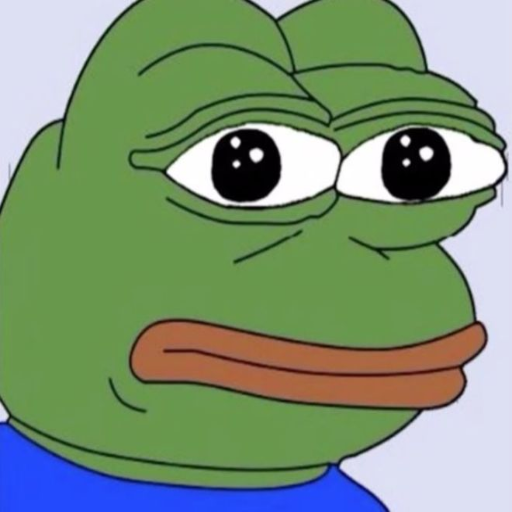

In [7]:
img = url_to_image('https://upload.wikimedia.org/wikipedia/uk/b/b3/Pepe_frog.jpg')

img = cv2.resize(img, (512, 512))

cv2_imshow(img)

## Сума всіх пікселів у зображенні по одному з каналів RGB кольорового зображення.

In [0]:
from numba import cuda, vectorize, jit

In [0]:
@jit(nopython=True)
def img_sum_numba(img, N):
  res = 0
  for i in range(N):
      res += img[i]
  return res

def img_sum_cpu(img):
  res = 0
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      res += img[i][j]
  return res

In [13]:
%%time
res_cpu = img_sum_cpu(img[:, :, 0])

CPU times: user 161 ms, sys: 0 ns, total: 161 ms
Wall time: 163 ms


In [14]:
%%time
res_numba = img_sum_numba(img[:, :, 0].ravel(), img.shape[0] * img.shape[1])

CPU times: user 456 µs, sys: 95 µs, total: 551 µs
Wall time: 359 µs


In [15]:
res_cpu == res_numba

True


## Пошук мінімального значення в одному з каналів RGB кольорового зображення із застосуванням підходу Reduction.

In [0]:
@jit(nb.uint8(nb.uint8[:]), cache=True, fastmath=True)
def channel_min_jit(X):
    return np.min(X)

@cuda.reduce
def channel_min_reduce(a, b):
  return min(a, b)

def channel_min_cpu(X):
  min_val = math.inf

  for i in range(len(X)):
    if X[i] < min_val:
      min_val = X[i]

  return min_val

In [19]:
%%time
res_cpu = channel_min_cpu(img[:, :, 0].ravel())

CPU times: user 60.3 ms, sys: 1.01 ms, total: 61.3 ms
Wall time: 61.4 ms


In [21]:
%%time
res_reduce = channel_min_reduce(img[:, :, 0].ravel())

CPU times: user 3.73 ms, sys: 1.08 ms, total: 4.82 ms
Wall time: 5.22 ms


In [23]:
%%time
res_jit = channel_min_jit(img[:, :, 0].ravel())

CPU times: user 775 µs, sys: 0 ns, total: 775 µs
Wall time: 486 µs


In [24]:
res_cpu == res_reduce == res_jit

True


## Розрахунок  згортки (конволюції) для кожного з RGB каналів зображення.

In [0]:
filt = np.array([[1, 0, -1],[1, 0, -1], [1, 0, -1]])

In [0]:
def cpu_conv(img, filt):
  out = np.zeros((img.shape[0] - 1, img.shape[1] - 1, img.shape[2]))
  filt_vec = filt.ravel()
  for i in prange(1, img.shape[0] - 1):
    for j in prange(1, img.shape[1] - 1):
      for k in prange(img.shape[2]):
        img_vec = img[i-1:i+2, j-1:j+2, k].ravel()
        out[i - 1][j - 1][k] = np.dot(img_vec, filt_vec)
  return out

In [0]:
@cuda.jit
def cuda_conv(img, out, filt, w, h):
  x, y = cuda.grid(2)

  if x >= h - 1 or y >= w - 1 or x == 0 or y == 0:
    return
  
  for c in range(3):
    res = 0
    for i in range(x - 1, x + 2):
      for j in range(y - 1, y + 2):
        res += img[i, j, c] * filt[i - x - 1, j - y - 1]
    out[x, y, c] = res


In [0]:
stream = cuda.stream()

out = np.zeros(img.shape)

w = img.shape[0]
h = img.shape[1]

c_img = cuda.to_device(img, stream=stream)
c_out = cuda.to_device(out, stream=stream)
c_filt = cuda.to_device(filt, stream=stream)

threadsperblock = (16, 16)
blockspergrid_x = math.ceil(img.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(img.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

In [61]:
%%time
cpu_conv_res = cpu_conv(img, filt)

CPU times: user 3.16 s, sys: 448 µs, total: 3.16 s
Wall time: 3.17 s


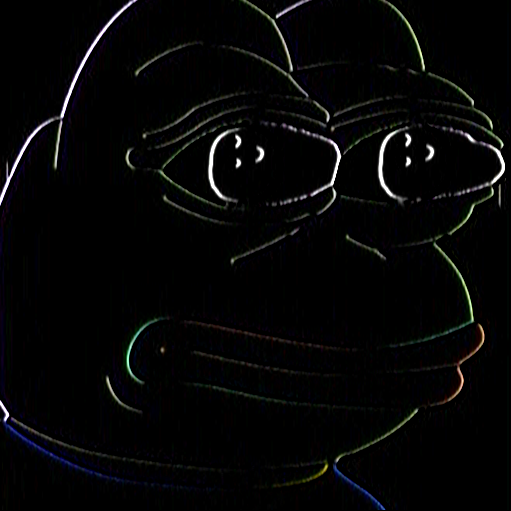

In [58]:
cv2_imshow(cpu_conv_res)

In [62]:
%%time
cuda_conv[blockspergrid, threadsperblock, stream](c_img, c_out, c_filt, w, h)

CPU times: user 295 ms, sys: 0 ns, total: 295 ms
Wall time: 295 ms


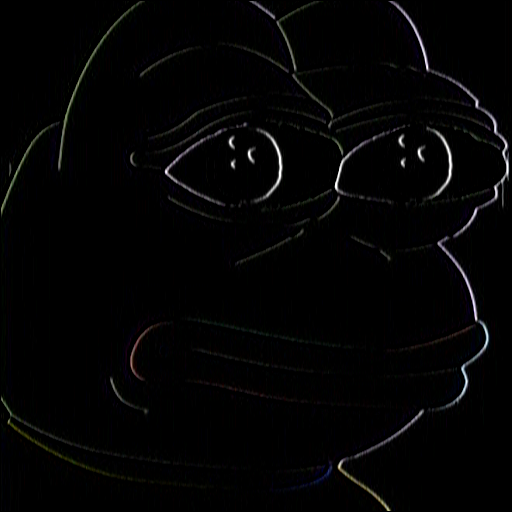

In [63]:
out = c_out.copy_to_host(out, stream=stream)
cv2_imshow(out)